### Want to see: 
- Still looking at change in neural activity projected onto preference axes
- Is the magnitude of this projection different for different belief partitions?
- Prediction for chose X, correct: 
  - low: larger
  - High X: lower, maybe negative
  - High not X: lower
- Prediction for chose X, incorrect: 
  - low, lower
  - High X: large negative 
  - High not X: lower




In [4]:
import os
import numpy as np
import pandas as pd
import utils.visualization_utils as visualization_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
import utils.classifier_utils as classifier_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
from constants.behavioral_constants import *
from constants.decoding_constants import *
from scripts.pseudo_decoding.belief_partitions.belief_partition_configs import *
import scripts.pseudo_decoding.belief_partitions.belief_partitions_io as belief_partitions_io
import itertools

import argparse
import copy
from tqdm import tqdm
import seaborn as sns

In [5]:
# conditions_maps = {
#     "chose X / correct / low": {"Response": "Correct", "Choice": "Chose", "BeliefPartition": "Low"},
#     "chose X / correct / high X": {"Response": "Correct", "Choice": "Chose", "BeliefPartition": "High X"},
#     "chose X / correct / high not X": {"Response": "Correct", "Choice": "Chose", "BeliefPartition": "High Not X"},
#     # "correct": {"Response": "Correct"},
#     # "incorrect": {"Response": "Incorrect"},
# }

conditions_maps = {
    "chose X / incorrect / low": {"Response": "Incorrect", "Choice": "Chose", "BeliefPartition": "Low"},
    "chose X / incorrect / high X": {"Response": "Incorrect", "Choice": "Chose", "BeliefPartition": "High X"},
    "chose X / incorrect / high not X": {"Response": "Incorrect", "Choice": "Chose", "BeliefPartition": "High Not X"},
    "chose X / correct / low": {"Response": "Correct", "Choice": "Chose", "BeliefPartition": "Low"},
    "chose X / correct / high X": {"Response": "Correct", "Choice": "Chose", "BeliefPartition": "High X"},
    "chose X / correct / high not X": {"Response": "Correct", "Choice": "Chose", "BeliefPartition": "High Not X"},
    # "correct": {"Response": "Correct"},
    # "incorrect": {"Response": "Incorrect"},
}

def read_all_cond_data(args):
    all_data = []
    for i, event in enumerate(["StimOnset", "FeedbackOnsetLong"]):
        all_conds = []
        for cond_name in conditions_maps:
            args.trial_event = event
            args.conditions = conditions_maps[cond_name]
            res = belief_partitions_io.read_update_projections(args)
            res["cond"] = res.apply(lambda x: "shuffle" if "shuffle" in x["mode"] else cond_name, axis=1)
            all_conds.append(res)
        all_conds = pd.concat(all_conds)
        all_conds["trial_event"] = event
        all_conds["Time"] = all_conds["TimeIdx"] / 10 + 0.1
        all_data.append(all_conds)
    return pd.concat(all_data)

In [6]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.subject = "both"
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.base_output_path = "/data/patrick_res/update_projections"
args.mode = "pref"
args.sig_unit_level = f"{args.mode}_99th_window_filter_drift"

# args.region_level = "structure_level2_cleaned"
# args.


In [7]:
res = read_all_cond_data(args)

In [8]:
# sub_res = res[~((res.trial_event == "FeedbackOnsetLong") & (res.Time > 0))]
# sub_res = res[~((res.trial_event == "StimOnset") & (res.Time < 0))]
# sub_res = res[~((res.trial_event == "FeedbackOnsetLong") & (res.Time > 0))]

sub_res = res

In [9]:
cor_res = sub_res[~sub_res.cond.str.contains("incorrect")]
inc_res = sub_res[~sub_res.cond.str.contains(" correct")]

{'shuffle': (0, -0.05108349737615994), 'chose X / correct / low': (1, 0.4333837438191022), 'chose X / correct / high X': (2, -0.531226425758072), 'chose X / correct / high not X': (3, 2.079981640376346)}
0.10399908201881727
1
0
text y pos: 2.1943806305970446
2
0
text y pos: 2.1943806305970446
3
0
text y pos: 2.1943806305970446
{'shuffle': (0, -0.05108349737615982), 'chose X / incorrect / low': (1, 0.0034869131301232606), 'chose X / incorrect / high X': (2, -0.8626976789403996), 'chose X / incorrect / high not X': (3, 0.5110131033756471)}
0.025550655168782372
1
0
text y pos: 0.5391188240613081
2
0
text y pos: 0.5391188240613081
3
0
text y pos: 0.5391188240613081


(<Figure size 1000x1000 with 2 Axes>, <Axes: xlabel='cond', ylabel='proj'>)

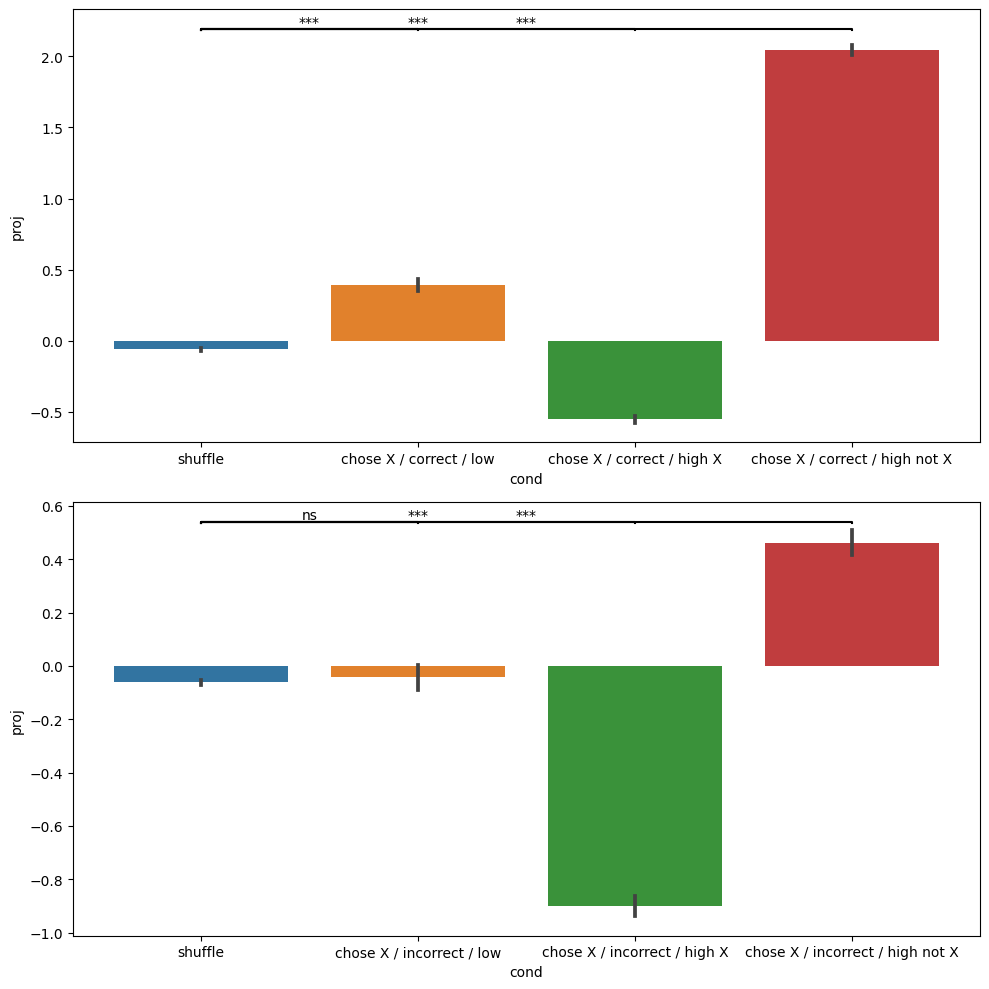

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

cor_order= ["shuffle", "chose X / correct / low", "chose X / correct / high X", "chose X / correct / high not X"]
cor_res = cor_res.sort_values(by="cond", key=lambda x: x.map(cor_order.index))
sns.barplot(cor_res, x="cond", y="proj", errorbar="se", ax=ax1, order=cor_order)
visualization_utils.add_significance_bars(fig, ax1, cor_res, "cond", "proj", pairs=[
    ("chose X / correct / low", "shuffle"),
    ("chose X / correct / high X", "shuffle"),
    ("chose X / correct / high not X", "shuffle"),
])

inc_order= ["shuffle", "chose X / incorrect / low", "chose X / incorrect / high X", "chose X / incorrect / high not X"]
inc_res = inc_res.sort_values(by="cond", key=lambda x: x.map(inc_order.index))
sns.barplot(inc_res, x="cond", y="proj", errorbar="se", ax=ax2, order=inc_order)
visualization_utils.add_significance_bars(fig, ax2, inc_res, "cond", "proj", pairs=[
    ("chose X / incorrect / low", "shuffle"),
    ("chose X / incorrect / high X", "shuffle"),
    ("chose X / incorrect / high not X", "shuffle"),
])
